# Modelling neural connectivity from fMRI data using  Bayesian Networks
### by Mattia Orlandi

This project was developed as part of the **Fundamentals of Artificial Intelligence and Knowledge Representation (Mod. 3)** course of the **Master in Artificial Intelligence** (*Alma Mater Studiorum, University of Bologna*).

## Introduction
*Functional magnetic resonance imaging* (**fMRI**) is a neuro-imaging technique which measures brain activity by detecting changes in the blood flow: in fact, when a specific brain region is in use, the blood flow in that region will increase, creating the so-called *blood-oxygen-level dependent* (**BOLD**) signal.
Such signal is the result of a superimposition of the activities of several local regions.

The aim of this project is to use **discrete Dynamic Bayesian Networks** (dDBNs) to analyse the BOLD signal of an fMRI in order to estimate a model for neural connectivity, and thus show how the brain regions involved interacts with each other; to do so, the *movie watching based brain development* dataset [[1](#first)], composed of fMRI data from both children and adults collected during a movie-watching task, is considered.

Finally, the dDBN's predicting performances will be assessed by comparing it with a (random) baseline.

This project makes use of the following libraries:
- `nilearn`, which provides neuroimaging tools;
- `pgmpy`, which provides support for Bayesian networks;
- `tslearn`, which provides tools for time series analysis. 

The `pgmpy` library currently [does not fully support learning continuous models](https://github.com/pgmpy/pgmpy/issues/1072); this is the reason why in this project a discrete DBN is employed.

## Data preprocessing

Firstly, the dataset is fetched using `nilearn` APIs. In particular, the data concerning only 30 adult subjects out of 155 is loaded (mixing data from children and adult subjects would distort results, since brain connectivity is very different for these two categories).

In [1]:
%load_ext autoreload
%autoreload 2
from nilearn import datasets
import warnings
warnings.filterwarnings('ignore')

# Fetch dataset
data = datasets.fetch_development_fmri(n_subjects=30, age_group='adult', data_dir='.')
data.keys()

dict_keys([&#39;func&#39;, &#39;confounds&#39;, &#39;phenotypic&#39;, &#39;description&#39;])

As it can be seen, the dataset is a dictionary containing four keys:
- **func**: paths to Nifti files, containing the downsampled fMRI (4D) images for each subject;
- **confounds**: paths to CSV files containing the nuisance variables (i.e. *confounds*) to take into account in order not to affect the analysis;
- **phenotypic**: information about subjects (e.g. age, age group, gender, etc.);
- **description**: a description of the dataset.

As previously mentioned, fMRI signal is the summation of the signals coming from multiple regions; therefore, the next step consists in separating such signal into simpler, non-overlapping spatial and time components. This can be done using **Canonical Independent Component Analysis** (*CanICA*) [[2](#second)]: `nilearn` provides the `CanICA` class which implements such algorithm. The documentation suggests a 20-component decomposition, but that would have resulted into a Bayesian network with 40 nodes (20 for the current time slice, and 20 for the following one). A network with such a high number of nodes would take a lot of time to perform search tasks (i.e. find the best network structure, find independencies between nodes, or perform sampling). Therefore, an 8-component decomposition was chosen.

In [2]:
from nilearn.decomposition import CanICA

# Perform Independent Component Analysis (ICA)
canica = CanICA(n_components=8,
                mask_strategy='template',
                verbose=1,
                memory="nilearn_cache",
                memory_level=1,
                random_state=42)
canica.fit(data.func)

# Retrieve the components
components_img = canica.components_img_

[MultiNiftiMasker.fit] Loading data from [./development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz, ./development_fmri/development_fmri/sub-pixar124_task-pixar_space-MNI152NLin2009cAsym_d
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.9s finished


Once the components have been extracted, it's possible to plot the ICs using two `nilearn` functions: `plot_prob_atlas()` stacks all the ICs as layers on top of the default anatomical brain image, whereas `plot_stat_map()` allows to plot cuts of the region of interest (ROI).

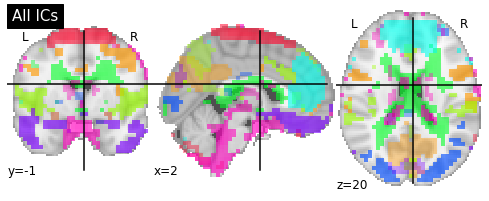

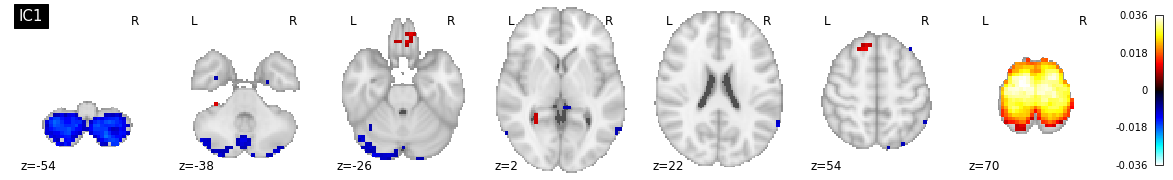

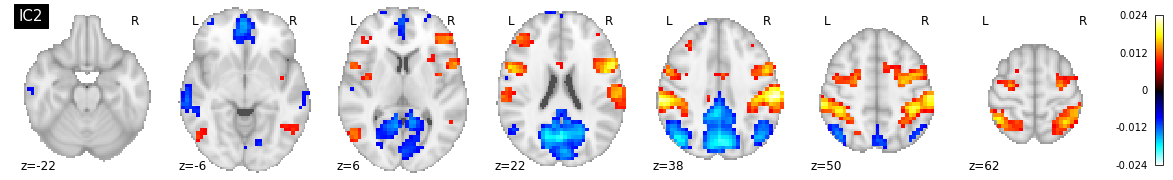

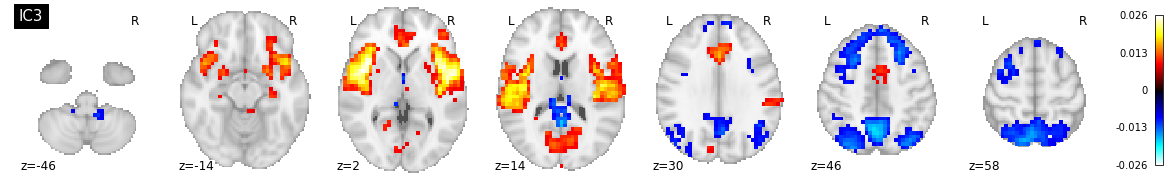

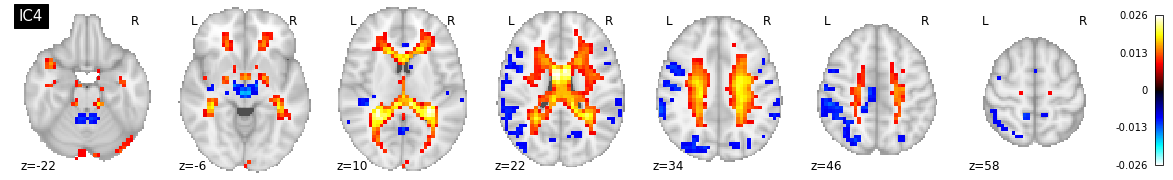

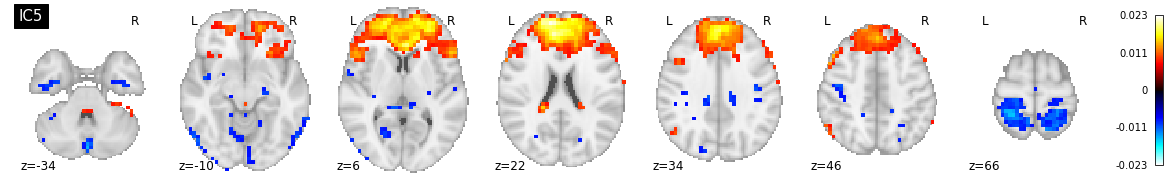

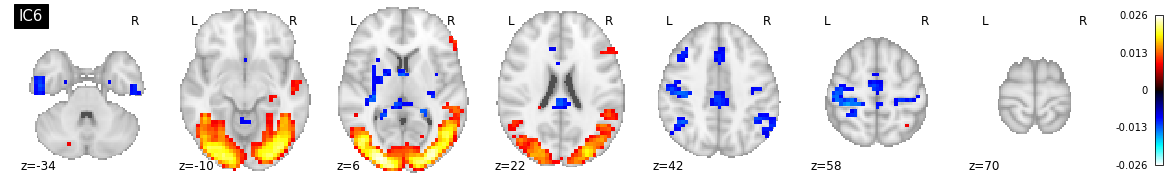

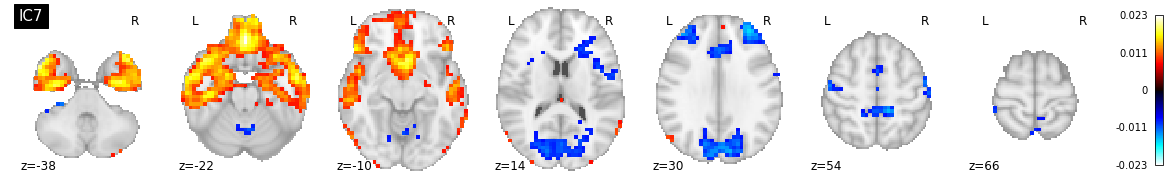

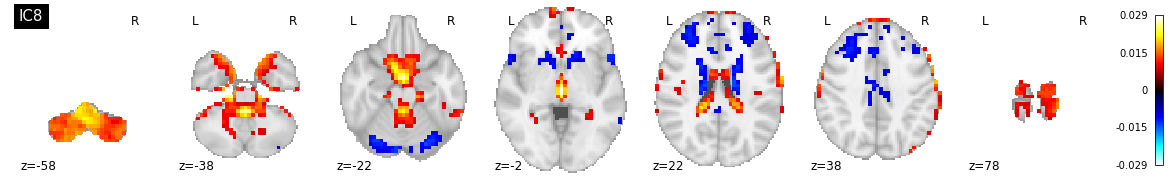

In [3]:
from nilearn import image, plotting

# Plot all ICs in a single image
plotting.plot_prob_atlas(components_img, title='All ICs')
plotting.show()

# Plot every IC in a separate image
for i, cur_img in enumerate(image.iter_img(components_img)):
    plotting.plot_stat_map(cur_img,
                           display_mode="z",
                           title=f'IC{i + 1}')

Then, the time series representing the signal must be extracted from each region; this can be done using the `NiftiMapsMasker` filter, and its `fit_transform()` function.

In [4]:
from nilearn.input_data import NiftiMapsMasker
import numpy as np

# Initialize masker
masker = NiftiMapsMasker(components_img,
                         standardize=True,
                         memory="nilearn_cache",
                         memory_level=2)

# Extract time series
time_series = []
for func_file, confound_file in zip(data.func, data.confounds):
    time_series.append(masker.fit_transform(func_file, confounds=confound_file))

print(f'Number of subjects: {len(time_series)}')

# Take the mean signal w.r.t. the subjects
time_series = np.mean(time_series, axis=0)

print(f'Length of time series: {time_series.shape[0]}')
print(f'Number of regions: {time_series.shape[1]}')

Number of subjects: 30
Length of time series: 168
Number of regions: 8


After taking the mean of each time series w.r.t. the 30 subjects, the data is stored in a ```pandas.DataFrame``` object: each column represents the region of the brain in which the signal was measured, and each row represents a time step.

In [5]:
import pandas as pd

labels = [f'IC{i + 1}' for i in range(time_series.shape[1])]

# Create dataframe of time series
list_of_series = [pd.Series(t) for t in time_series.T]
df = pd.concat(list_of_series, axis=1)
df.columns = labels

df.head(10)

,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8
0,0.338745,0.596882,0.790906,-0.000330,0.536538,-2.012571,0.148631,-0.412821
1,0.310135,0.395740,0.743083,0.283444,0.666323,-1.910853,-0.282963,-0.689739
2,0.305966,-0.146917,0.319023,-0.067170,0.691875,-1.728914,-0.596410,-0.308568
3,-0.142621,-0.466608,0.249193,-0.192379,0.574393,-1.849020,-0.072281,-0.391290
4,0.210432,-0.371078,0.174356,-0.288709,0.545181,-1.991428,-0.713120,-0.404959
5,0.124055,-0.358309,0.464483,-0.362982,0.447671,-1.982489,-0.550741,-0.196211
6,0.132488,-0.111320,0.518965,0.027917,0.945455,-2.303297,-0.596432,-0.339596
7,0.186570,-0.046322,0.457225,0.141313,0.711444,-1.544538,-0.318726,-0.174288
8,-0.036690,-0.284918,0.073206,-0.041135,0.450858,-0.602798,-0.004133,-0.242470
9,-0.373583,-0.332825,0.080593,-0.120992,0.135806,-0.006950,0.179673,-0.405081


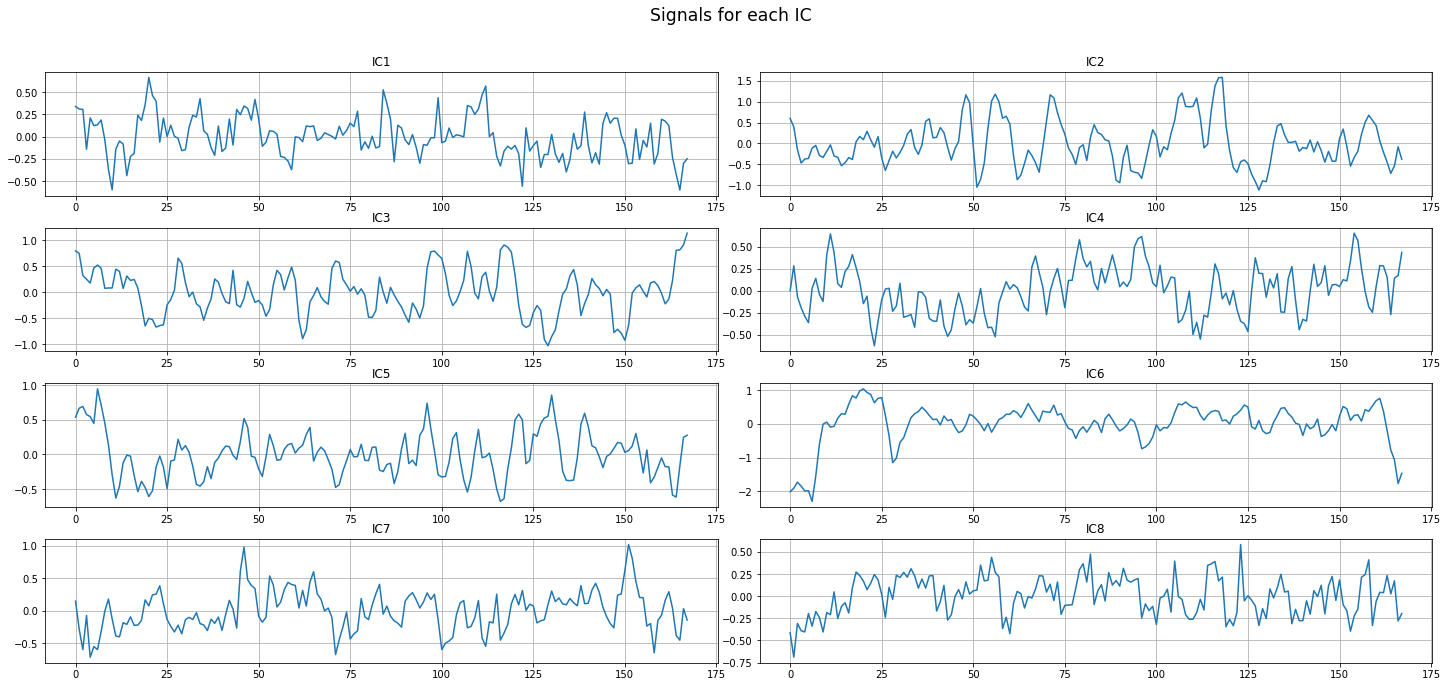

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

_, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 10))
plt.suptitle('Signals for each IC', size='xx-large')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for i, col in enumerate(df):
    id1 = i // 2
    id2 = i % 2
    df[col].plot(ax=axes[id1, id2], grid=True, title=col)

Since the aim of the project is developing a discrete DBN, the signal must be discretized; before doing so, the signal is normalized s.t. it will have mean $\mu=0$ and standard deviation $\sigma=1$ [[3](#third)]. 

In [7]:
# Normalize dataframe
df = (df - df.mean()) / df.std()

df.head(10)

,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8
0,1.464128,1.090801,1.823102,-0.001200,1.637900,-3.352963,0.480845,-1.864490
1,1.340471,0.723214,1.712867,1.031621,2.034097,-3.183499,-0.915433,-3.115176
2,1.322449,-0.268491,0.735374,-0.244471,2.112102,-2.880388,-1.929484,-1.393634
3,-0.616439,-0.852725,0.574411,-0.700181,1.753463,-3.080485,-0.233842,-1.767244
4,0.909533,-0.678144,0.401904,-1.050781,1.664286,-3.317739,-2.307058,-1.828979
5,0.536193,-0.654810,1.070671,-1.321107,1.366613,-3.302846,-1.781736,-0.886178
6,0.572642,-0.203436,1.196256,0.101607,2.886211,-3.837316,-1.929555,-1.533773
7,0.806393,-0.084653,1.053940,0.514320,2.171839,-2.573216,-1.031131,-0.787164
8,-0.158581,-0.520688,0.168747,-0.149714,1.376343,-1.004268,-0.013371,-1.095106
9,-1.614704,-0.608236,0.185772,-0.440359,0.414579,-0.011578,0.581271,-1.829531


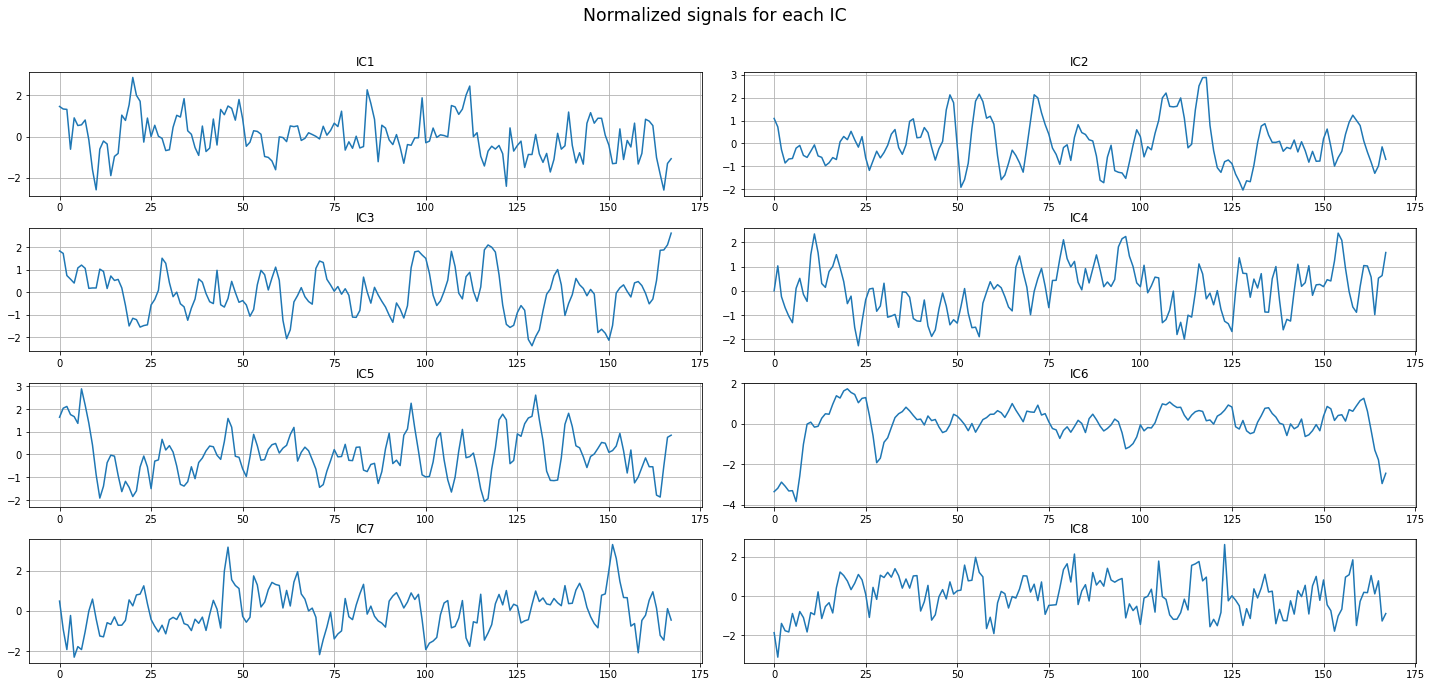

In [8]:
_, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 10))
plt.suptitle('Normalized signals for each IC', size='xx-large')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for i, col in enumerate(df):
    id1 = i // 2
    id2 = i % 2
    df[col].plot(ax=axes[id1, id2], grid=True, title=col)

After the normalization, the signal is discretized using four tiers; given $V_{min}$ and $V_{max}$, respectively the minimum and maximum values across the time series, then the current continuous value of the signal $V_{cont}$ is discretized according to the following rules [[3](#third)]:
- 'Very Low' if $V_{cont} \lt \frac{V_{min}}{2}$;
- 'Low' if $\frac{V_{min}}{2} \leq V_{cont} \lt 0$;
- 'High' if $0 \leq V_{cont} \lt \frac{V_{max}}{2}$;
- 'Very High' if $V_{cont} \geq \frac{V_{max}}{2}$.

In [9]:
def discretize_series(series):
    # Find minimum and maximum values of the series, and define boundaries
    s_min, s_max = series.min(), series.max()
    boundaries = [s_min / 2., 0., s_max / 2.]
    
    # Assign tier based on the boundaries
    def get_tier(val):
        if val < boundaries[0]:
            return 'Very Low'
        elif val >= boundaries[0] and val < boundaries[1]:
            return 'Low'
        elif val >= boundaries[1] and val < boundaries[2]:
            return 'High'
        else:
            return 'Very High'
    
    return pd.Series([get_tier(val) for val in series])

list_of_series = [discretize_series(df[col]) for col in df]
df = pd.concat(list_of_series, axis=1)
df.columns = labels

df.head(10)

,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8
0,Very High,High,Very High,Low,Very High,Very Low,High,Very Low
1,High,High,Very High,High,Very High,Very Low,Low,Very Low
2,High,Low,High,Low,Very High,Very Low,Very Low,Low
3,Low,Low,High,Low,Very High,Very Low,Low,Very Low
4,High,Low,High,Low,Very High,Very Low,Very Low,Very Low
5,High,Low,High,Very Low,High,Very Low,Very Low,Low
6,High,Low,High,High,Very High,Very Low,Very Low,Low
7,High,Low,High,High,Very High,Very Low,Low,Low
8,Low,Low,High,Low,High,Low,Low,Low
9,Very Low,Low,High,Low,High,Low,High,Very Low


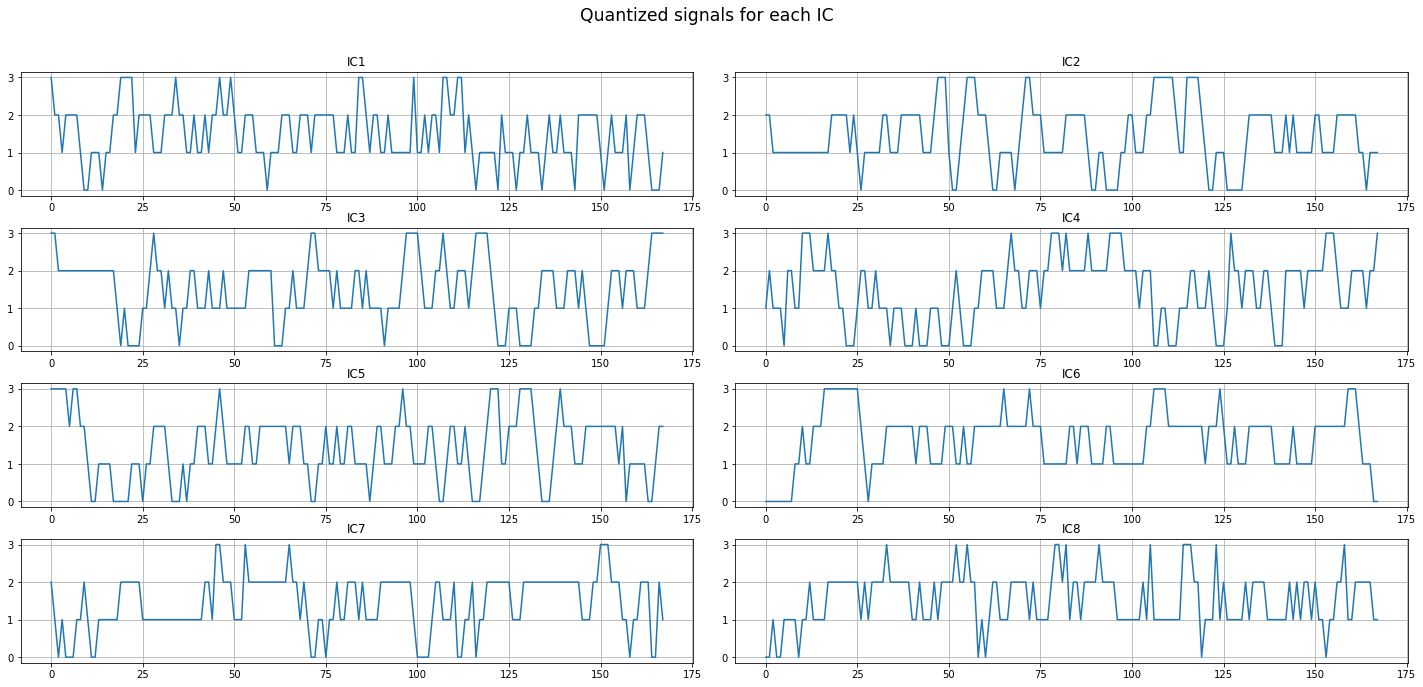

In [10]:
_, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 10))
plt.suptitle('Quantized signals for each IC', size='xx-large')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

quantize_enc = {'Very Low': 0,
                'Low': 1,
                'High': 2,
                'Very High': 3}
for i, col in enumerate(df):
    id1 = i // 2
    id2 = i % 2
    s = [quantize_enc[v] for v in df[col]]
    axes[id1, id2].plot(s)
    axes[id1, id2].set_title(col)
    axes[id1, id2].grid()

Then, we split the dataframe in a training set and in a test set; this will be useful to assess the DBNs performances in generating a synthetic time series.

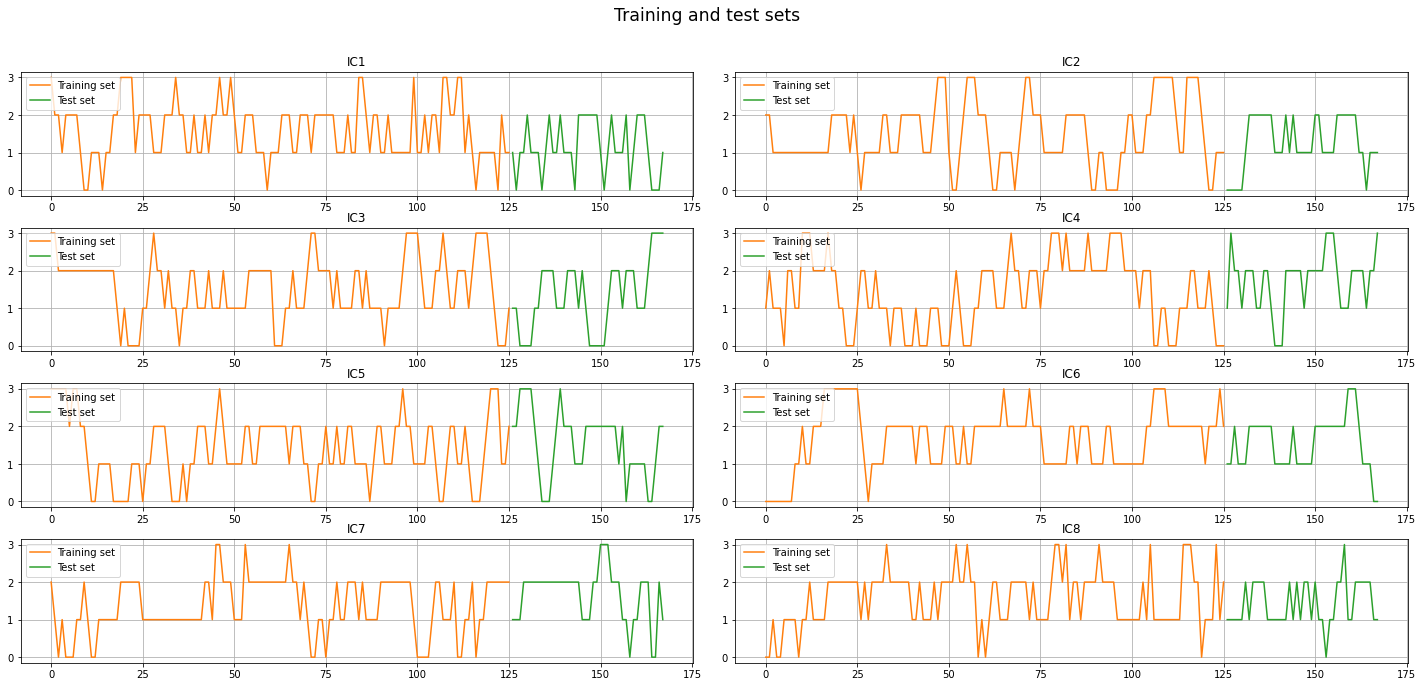

In [11]:
# Prepare mask
train_size = int(3/4 * len(df))
test_size = len(df) - train_size
train_mask = np.ones(train_size, dtype=bool)
test_mask = np.zeros(test_size, dtype=bool)
mask = np.concatenate([train_mask, test_mask])
# Split dataframe in training (2/3) and test (1/3) sets
df_train = df[mask]
df_test = df[~mask]

_, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 10))
plt.suptitle('Training and test sets', size='xx-large')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for i, col in enumerate(df):
    id1 = i // 2
    id2 = i % 2
    x_data = range(len(df))
    s_train = [quantize_enc[v] for v in df_train[col]]
    s_test = [quantize_enc[v] for v in df_test[col]]
    axes[id1, id2].plot(x_data[:train_size], s_train, 'C1', label='Training set')
    axes[id1, id2].plot(x_data[train_size:], s_test, 'C2', label='Test set')
    axes[id1, id2].set_title(col)
    axes[id1, id2].legend(loc='upper left')
    axes[id1, id2].grid()

The dDBN to be learnt is a 2-TBN, i.e. a discrete dynamic BN considering only 2 time slices. Therefore, the final preprocessing step consists in 'unrolling' the training set: the columns of the dataframe are doubled, s.t. the original columns will represent the value of the signal in the current time step, whereas the new ones will represent the value of the signal in the following time step. As a side effect, the length of each time series will be 125 instead of 126.

In [12]:
def unroll_series(series):
    # Copy the original series
    next_series = series.copy()
    series = series[:-1].reset_index(drop=True)
    next_series = next_series[1:].reset_index(drop=True)
    return series, next_series

# Unroll time series and flatten
list_of_series = [unroll_series(df_train[col]) for col in df]
list_of_series = [v for t in list_of_series for v in t]
# Create new labels and flatten
new_labels = [(f'{l}_T', f'{l}_T+1') for l in labels]
new_labels = [l for t in new_labels for l in t]

# Create new dataframe
unrolled_df_train = pd.concat(list_of_series, axis=1)
unrolled_df_train.columns = new_labels

print(f'Length of the time series after unrolling phase: {unrolled_df_train.shape[0]}')
print('-' * 50)
unrolled_df_train.head(10)

Length of the time series after unrolling phase: 125
--------------------------------------------------


,IC1_T,IC1_T+1,IC2_T,IC2_T+1,IC3_T,IC3_T+1,IC4_T,IC4_T+1,IC5_T,IC5_T+1,IC6_T,IC6_T+1,IC7_T,IC7_T+1,IC8_T,IC8_T+1
0,Very High,High,High,High,Very High,Very High,Low,High,Very High,Very High,Very Low,Very Low,High,Low,Very Low,Very Low
1,High,High,High,Low,Very High,High,High,Low,Very High,Very High,Very Low,Very Low,Low,Very Low,Very Low,Low
2,High,Low,Low,Low,High,High,Low,Low,Very High,Very High,Very Low,Very Low,Very Low,Low,Low,Very Low
3,Low,High,Low,Low,High,High,Low,Low,Very High,Very High,Very Low,Very Low,Low,Very Low,Very Low,Very Low
4,High,High,Low,Low,High,High,Low,Very Low,Very High,High,Very Low,Very Low,Very Low,Very Low,Very Low,Low
5,High,High,Low,Low,High,High,Very Low,High,High,Very High,Very Low,Very Low,Very Low,Very Low,Low,Low
6,High,High,Low,Low,High,High,High,High,Very High,Very High,Very Low,Very Low,Very Low,Low,Low,Low
7,High,Low,Low,Low,High,High,High,Low,Very High,High,Very Low,Low,Low,Low,Low,Low
8,Low,Very Low,Low,Low,High,High,Low,Low,High,High,Low,Low,Low,High,Low,Very Low
9,Very Low,Very Low,Low,Low,High,High,Low,Very High,High,Low,Low,High,High,Low,Very Low,Low


## Structure learning
After the preprocessing phase, the data is ready to be used to learn the dDBN. However, since `pgmpy` does not support learning a dynamic BN, the model that will be learnt will be a static BN. This is possible thanks to the 'unrolling' preprocessing step: in fact, the nodes belonging to the 'current' and 'next' time slices are treated as if they were standard nodes in a static BN. Therefore, the only things to keep in mind are the constraints due to the dynamic nature of the DBN [[4](#fourth)]:
- **causality constraint**: a node in the current time slice cannot be influenced by a node in the following time slice;
- **isochronal constraint**: a node in a time slice cannot influence other nodes in the same time slice;
- **continuity constraint**: a node in the current time slice will influence itself in the following time slice.

The search strategy employed is the **forward stepwise selection** [[3](#third)]:
- scan every 'next' node $X_n$;
- scan every 'current' node $X_c$;
- add $X_c$ as parent of $X_n$, measure structure score and remove such edge;
- re-add and keep only the edge producing the best score and repeat $indegree$ times.

Causality and isochronal constraints are already intrinsically taken into account by the search algorithm; on the other hand, continuity constraints are enforced when creating the initial model.

As in Burge et al.'s paper [[3](#third)], the *Bayesian Dirichlet equivalent uniform* prior (**BDeu**) score is used to assess the quality of a structure. Nevertheless, there are some differences in this implementation of forward stepwise selection w.r.t. the paper: in fact, the algorithm employed by Burge et al. also takes into account an additional node, representing the stimulus, connected to all the others; however, since in this case the stimulus (a movie) is active throughout all the fMRI recording, a node representing such stimulus would not carry any additional information, and thus it is not included. Moreover, Burge et al. do not impose any continuity constraint.

To speed-up the search, multi-core programming is exploited using `concurrent.futures.ProcessPoolExecutor` APIs.

In [13]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import BDeuScore
from concurrent.futures import ProcessPoolExecutor
import itertools, functools
import psutil
import time

# Define function for evaluating each edge connecting to X_n
def edge_eval(x_c, x_n, model, estimator):
    copy = model.copy()
    copy.add_edge(x_c, x_n)
    return estimator.score(copy)

def forward_stepwise_selection(current_nodes, next_nodes, indegree, estimator, verbose = False):
    assert indegree <= len(current_nodes), 'Indegree should not be greater than the number of nodes in a'

    start_time = time.time()
    
    # Initialize model with continuity constraints
    continuity_constraints = list(zip(current_nodes, next_nodes))
    model = BayesianModel(continuity_constraints)

    # Create support dictionary to find node ICX_t from ICX_t+1
    node_map = dict([(n, c) for c, n, in continuity_constraints])
    
    # Get number of available cores
    n_procs = psutil.cpu_count(logical=False)
    if verbose:
        print(f'Using {n_procs} cores')
        print('-' * 50)
    
    # If indegree is equal to the total number of nodes in the current slice,
    # speed up the search by simply constructing a dense network
    if indegree == len(current_nodes):
        if verbose:
            print('Building dense network...')
        edges = list(itertools.product(current_nodes, next_nodes))
        model.add_edges_from(edges)
    else:
        # Scan next nodes
        for x_n in next_nodes:
            if verbose:
                print(f'Finding parents of node {x_n}...')
            
            # Keep track of already added nodes to avoid repetitions
            # Take continuity constraints into account in the added nodes
            added_nodes = set()
            added_nodes.add(node_map[x_n])
            # Loop is repeated (indegree - 1) times since one parent node 
            # has already been added due to continuity constraints
            for _ in range(indegree - 1):
                # Consider as testable only non-looping nodes
                testable_nodes = set(current_nodes).difference(added_nodes)

                # Use multiprocessing to speed-up search
                with ProcessPoolExecutor(max_workers=n_procs) as executor:
                    # Fix estimator, model and x_n parameters and feed the partial function to the executor
                    edge_eval_par = functools.partial(edge_eval, estimator=estimator, model=model, x_n=x_n)
                    scores = dict(zip(testable_nodes, executor.map(edge_eval_par,
                                                                   testable_nodes)))
                node_to_add = max(scores, key=scores.get)
                best_score = scores[node_to_add]
                model.add_edge(node_to_add, x_n)
                added_nodes.add(node_to_add)
                if verbose:
                    print(f'\t Added {node_to_add} with {best_score:.2f}')
    final_score = estimator.score(model)
    if verbose:
        print('-' * 50)
        print(f'Running time: {time.time() - start_time:.2f} s')
    return model, final_score

# Divide nodes into two categories, 'current' (time slice t) and 'next' (time slice t+1)
c_nodes, n_nodes = [], []
for i, n in enumerate(new_labels):
    if i % 2 == 0:
        c_nodes.append(n)
    else:
        n_nodes.append(n)

# Create BDeu estimator with default parameters
est = BDeuScore(unrolled_df_train)

The number of parents a 'next' node can have (i.e. $indegree$) is a hyper-parameter: it is possible to determine it using a grid search. The chosen parameter space is $[2..8]$: in particular, the lower bound forces one region to be connected to (at least) another one, in addition to its future state.

In [14]:
def grid_search(indegree_range, current_nodes, next_nodes, estimator):
    scores = dict()
    for indegree in indegree_range:
        start_time = time.time()
        model, score = forward_stepwise_selection(current_nodes, next_nodes, indegree, estimator)
        scores[indegree] = score
        print(f'Testing indegree={indegree} with score {score:.2f} [{time.time() - start_time:.2f} s]...')
    
    return max(scores, key=scores.get)

param_space = [2, 3, 4, 5, 6, 7, 8]
start_time = time.time()
best_indeg = grid_search(param_space, c_nodes, n_nodes, est)
print('-' * 50)
print(f'Best indegree of the model: {best_indeg}')
print(f'Total running time: {time.time() - start_time:.2f} s')

Testing indegree=2 with score -2399.45 [2.15 s]...
Testing indegree=3 with score -2630.49 [3.81 s]...
Testing indegree=4 with score -2884.67 [5.51 s]...
Testing indegree=5 with score -2951.99 [5.68 s]...
Testing indegree=6 with score -2808.34 [7.81 s]...
Testing indegree=7 with score -2720.59 [28.71 s]...
Testing indegree=8 with score -2724.46 [1.91 s]...
--------------------------------------------------
Best indegree of the model: 2
Total running time: 55.59 s


The grid search showed that the optimal number of parents for a 'next' node is $indegree=2$: therefore, the model's structure is searched using such value for the hyper-parameter.

In [15]:
static_model, score = forward_stepwise_selection(c_nodes, n_nodes, best_indeg, est, verbose=True)
print(f'Score of the model: {score:.2f}')

Using 6 cores
--------------------------------------------------
Finding parents of node IC1_T+1...
	 Added IC8_T with -2305.66
Finding parents of node IC2_T+1...
	 Added IC8_T with -2314.08
Finding parents of node IC3_T+1...
	 Added IC7_T with -2328.67
Finding parents of node IC4_T+1...
	 Added IC1_T with -2346.87
Finding parents of node IC5_T+1...
	 Added IC1_T with -2363.68
Finding parents of node IC6_T+1...
	 Added IC8_T with -2373.62
Finding parents of node IC7_T+1...
	 Added IC8_T with -2385.65
Finding parents of node IC8_T+1...
	 Added IC5_T with -2399.45
--------------------------------------------------
Running time: 1.82 s
Score of the model: -2399.45


In [16]:
from pgmpy.models import DynamicBayesianNetwork
import operator

def print_edges(model):
    if isinstance(model, BayesianModel):
        edges = model.edges()
    elif isinstance(model, DynamicBayesianNetwork):
        edges = model.get_inter_edges()
    else:
        raise TypeError('Expected BayesianModel or DynamicBayesianNetwork.')
    groups = itertools.groupby(model.edges(), operator.itemgetter(0))
    for parent, childs in groups:
        print(parent)
        for child in childs:
            print(f'|-- {child[1]}')
    print('-' * 25)
    print(f'Total number of edges: {len(model.edges())}')

print_edges(static_model)

IC1_T
|-- IC1_T+1
|-- IC4_T+1
|-- IC5_T+1
IC2_T
|-- IC2_T+1
IC3_T
|-- IC3_T+1
IC4_T
|-- IC4_T+1
IC5_T
|-- IC5_T+1
|-- IC8_T+1
IC6_T
|-- IC6_T+1
IC7_T
|-- IC7_T+1
|-- IC3_T+1
IC8_T
|-- IC8_T+1
|-- IC1_T+1
|-- IC2_T+1
|-- IC6_T+1
|-- IC7_T+1
-------------------------
Total number of edges: 16


## Parameter learning
Once the structure is learnt, it is possible to also learn the conditional probability table (CPT) of the network. This can be done in two ways using `pgmpy`:
- **Maximum Likelihood Estimation (MLE)**: exploits relative frequencies to estimate the CPDs, and thus tends to overfit in case of small datasets;
- **Bayesian Parameter Estimation**: relies on prior CPDs (e.g. BDeu), and is more robust than MLE.

As in the forward stepwise selection, BDeu is chosen as CPD prior. By default, in the case of BDeu score the equivalent sample size, which is the number of generated uniform samples that are added to state counts for each parent configuration, is 10: thus, the same value is used for BDeu CPD prior.

To estimate the model's CPT, it suffices to call the `fit()` method of the `BayesianModel` class, pass to it an instance of `BayesianEstimator` and specify the prior.

In [17]:
from pgmpy.estimators import BayesianEstimator

static_model.fit(data=unrolled_df_train,
                 estimator=BayesianEstimator,
                 prior_type='BDeu',
                 equivalent_sample_size=10)

print(f'Model check: {static_model.check_model()}')
print('-' * 25)
for cpd in static_model.get_cpds():
    print(f'CPT for {cpd.variable} node:')
    print(cpd, '\n')

Model check: True
-------------------------
CPT for IC1_T node:
+------------------+----------+
| IC1_T(High)      | 0.396296 |
+------------------+----------+
| IC1_T(Low)       | 0.411111 |
+------------------+----------+
| IC1_T(Very High) | 0.12963  |
+------------------+----------+
| IC1_T(Very Low)  | 0.062963 |
+------------------+----------+ 

CPT for IC1_T+1 node:
+--------------------+----------------------+----------------------+----------------------+---------------------+-----------------------+---------------------+---------------------+----------------------+----------------------+----------------------+------------------+---------------------+-----------------+----------------------+---------------------+---------------------+
| IC1_T              | IC1_T(High)          | IC1_T(High)          | IC1_T(High)          | IC1_T(High)         | IC1_T(Low)            | IC1_T(Low)          | IC1_T(Low)          | IC1_T(Low)           | IC1_T(Very High)     | IC1_T(Very High)   

## From static to dynamic network
Now that both the structure of the network and its CPTs have been learnt, it's possible to convert the static model developed so far into a dynamic one.

In order to make inference methods work, `pgmpy` [would require to define all edges in the first time slice](https://github.com/pgmpy/pgmpy/issues/714); however, by doing so it could not be possible to model a dDBN with functional loops over time, which is a desired property of DBNs [[5](#fifth)] (in fact, [loops would appear](https://github.com/pgmpy/pgmpy/issues/1340) as if they were in the first time slice, thus violating the *acyclic* hypothesis of BNs).

Since it is still possible to define a `DynamicBayesianNetwork` with loops over time (but it's not possible to perform inference on that in `pgmpy`), as a design choice the dynamic model in the following section preserves loops; then, inference will instead be performed on the static model learned so far.

In [18]:
# Create support dictionary to find node ICX_t from ICX_t+1, and to find node ICX from ICX_t
next_to_curr_map = dict([(n, c) for c, n, in zip(c_nodes, n_nodes)])
stat_to_dyn_map = dict([(new_l, l) for l, new_l in zip(labels, new_labels[::2])])

dynamic_edges = [((stat_to_dyn_map[c], 0), (stat_to_dyn_map[next_to_curr_map[n]], 1)) for c, n in static_model.edges()]
dynamic_model = DynamicBayesianNetwork(dynamic_edges)

print_edges(dynamic_model)

(&#39;IC1&#39;, 0)
|-- (&#39;IC1&#39;, 1)
|-- (&#39;IC4&#39;, 1)
|-- (&#39;IC5&#39;, 1)
(&#39;IC4&#39;, 0)
|-- (&#39;IC4&#39;, 1)
(&#39;IC5&#39;, 0)
|-- (&#39;IC5&#39;, 1)
|-- (&#39;IC8&#39;, 1)
(&#39;IC2&#39;, 0)
|-- (&#39;IC2&#39;, 1)
(&#39;IC3&#39;, 0)
|-- (&#39;IC3&#39;, 1)
(&#39;IC8&#39;, 0)
|-- (&#39;IC8&#39;, 1)
|-- (&#39;IC1&#39;, 1)
|-- (&#39;IC2&#39;, 1)
|-- (&#39;IC6&#39;, 1)
|-- (&#39;IC7&#39;, 1)
(&#39;IC6&#39;, 0)
|-- (&#39;IC6&#39;, 1)
(&#39;IC7&#39;, 0)
|-- (&#39;IC7&#39;, 1)
|-- (&#39;IC3&#39;, 1)
-------------------------
Total number of edges: 16


The graphical representation of such network is shown below:

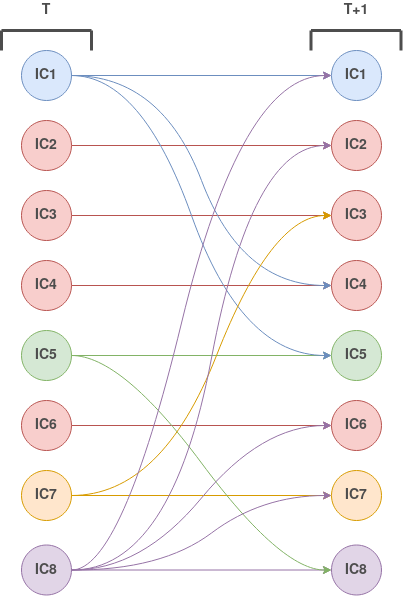

As it can be seen, only a certain subset of regions (half of them) influences other regions: in particular, IC8, with its 4 connections (excluding the one with its future self), is the most influential one, followed by IC1 with 2 connections, and IC5 and IC7 with 1 connection each (excluding the ones with their future selves). On the other hand, the remaining regions influence only their future selves.

Certain regions form loops over time: for example, IC8 at time T influences IC7 at time T+1, and likewise IC7 at time T influences IC8 at time T+1.

Now that the structure learnt using static BN is replicated in the dynamic BN, the CPTs must be also transferred.

In [19]:
from pgmpy.factors.discrete import TabularCPD
from functools import reduce
from operator import mul

# Mapping from any node to its original label
def get_dynamic_node(node):
    return (stat_to_dyn_map[node], 0) if node.endswith('_T') else (stat_to_dyn_map[next_to_curr_map[node]], 1)

# Extract information about CPDs of the static model
cpds_info = [{'variable': get_dynamic_node(cpd.variable),
              'variable_card': 4,
              'values': cpd.get_values(),
              'evidence': list(reversed([(stat_to_dyn_map[e], 0) for e in cpd.get_evidence()])) if len(cpd.get_evidence()) > 0 else None,
              'evidence_card': [4] * len(cpd.get_evidence()) if len(cpd.get_evidence()) > 0 else None,
              'state_names': dict([(get_dynamic_node(k), v) for k, v in cpd.state_names.items()])} for cpd in static_model.get_cpds()]

dynamic_cpds = [TabularCPD(**cpd_info) for cpd_info in cpds_info]
dynamic_model.add_cpds(*dynamic_cpds)
dynamic_model.initialize_initial_state()

print(f'Model check: {dynamic_model.check_model()}')
print('-' * 25)
print('===== Time slice T =====')
for cpd in dynamic_model.get_cpds():
    print(f'CPT for {cpd.variable} node:')
    print(cpd, '\n')
print('===== Time slice T+1 =====')
for cpd in dynamic_model.get_cpds(time_slice=1):
    print(f'CPT for {cpd.variable} node:')
    print(cpd, '\n')

Model check: True
-------------------------
===== Time slice T =====
CPT for (&#39;IC2&#39;, 0) node:
+-----------------------+----------+
| (&#39;IC2&#39;, 0)(High)      | 0.292593 |
+-----------------------+----------+
| (&#39;IC2&#39;, 0)(Low)       | 0.433333 |
+-----------------------+----------+
| (&#39;IC2&#39;, 0)(Very High) | 0.151852 |
+-----------------------+----------+
| (&#39;IC2&#39;, 0)(Very Low)  | 0.122222 |
+-----------------------+----------+ 

CPT for (&#39;IC3&#39;, 0) node:
+-----------------------+----------+
| (&#39;IC3&#39;, 0)(High)      | 0.396296 |
+-----------------------+----------+
| (&#39;IC3&#39;, 0)(Low)       | 0.366667 |
+-----------------------+----------+
| (&#39;IC3&#39;, 0)(Very High) | 0.122222 |
+-----------------------+----------+
| (&#39;IC3&#39;, 0)(Very Low)  | 0.114815 |
+-----------------------+----------+ 

CPT for (&#39;IC5&#39;, 0) node:
+-----------------------+----------+
| (&#39;IC5&#39;, 0)(High)      | 0.322222 |
+---------------

## Network analysis
The `pgmpy` library provides tools to investigate several properties of the dDBN; for instance, it's possible to:
- Find every **independency** between the network's nodes, w.r.t. all possible given evidence, and in particular find **local independencies**.
- Find the **Markov blanket** of a node, namely the set consisting of the node's parents, children, and children's parents; such set makes the node conditionally independent of the rest of the network.
- Find the **active trails** between two nodes, namely the path connecting the two nodes and along which probabilistic inference can flow.

In [20]:
# WARNING: pgmpy 0.1.11dev is affected by some bugs related to DynamicBayesianNetwork, due to the fact that dynamic nodes are represented
# as tuples (label, timeslice); this leads to problems when iterating through nodes, i.e. a single node is incorrectly treated as two distinct nodes.
# Therefore, I cloned the library, fixed it locally, and submitted a pull request (https://github.com/pgmpy/pgmpy/pull/1332).
# In particular, the methods affected are the following:
# - get_markov_blanket on leaf nodes -> https://github.com/pgmpy/pgmpy/issues/1331
# - get_independencies -> https://github.com/pgmpy/pgmpy/issues/1338
# - active_trail_nodes (workaround: wrap the node into a list before passing it to the method) -> https://github.com/pgmpy/pgmpy/issues/1334
# - print IndependencyAssertion objects -> https://github.com/pgmpy/pgmpy/issues/1339

for n in dynamic_model.nodes():
    print(f'Markov blanket of node {n}: {dynamic_model.get_markov_blanket(node=n)}')
print('-' * 150)

def active_trail(node, evidence = []):
    reachable = dynamic_model.active_trail_nodes([node], observed=evidence).get(node)
    reachable.remove(node)
    if reachable:
        if evidence:
            print(f'Active trail between {node} and {reachable} given {evidence}')
        else:
            print(f'Active trail between {node} and {reachable} given no evidence')
    else:
        if evidence:
            print(f'No active trails from {node} given {evidence}')
        else:
            print(f'No active trails from {node} given no evidence')

active_trail(('IC7', 0))
active_trail(('IC7', 0), evidence=[('IC7', 1)])
active_trail(('IC7', 0), evidence=[('IC3', 0), ('IC3', 1), ('IC7', 1), ('IC8', 0)])

Markov blanket of node (&#39;IC1&#39;, 0): [(&#39;IC4&#39;, 0), (&#39;IC5&#39;, 0), (&#39;IC8&#39;, 0), (&#39;IC4&#39;, 1), (&#39;IC1&#39;, 1), (&#39;IC5&#39;, 1)]
Markov blanket of node (&#39;IC1&#39;, 1): [(&#39;IC1&#39;, 0), (&#39;IC8&#39;, 0)]
Markov blanket of node (&#39;IC4&#39;, 1): [(&#39;IC1&#39;, 0), (&#39;IC4&#39;, 0)]
Markov blanket of node (&#39;IC4&#39;, 0): [(&#39;IC1&#39;, 0), (&#39;IC4&#39;, 1)]
Markov blanket of node (&#39;IC5&#39;, 1): [(&#39;IC1&#39;, 0), (&#39;IC5&#39;, 0)]
Markov blanket of node (&#39;IC5&#39;, 0): [(&#39;IC1&#39;, 0), (&#39;IC8&#39;, 1), (&#39;IC8&#39;, 0), (&#39;IC5&#39;, 1)]
Markov blanket of node (&#39;IC2&#39;, 0): [(&#39;IC2&#39;, 1), (&#39;IC8&#39;, 0)]
Markov blanket of node (&#39;IC2&#39;, 1): [(&#39;IC2&#39;, 0), (&#39;IC8&#39;, 0)]
Markov blanket of node (&#39;IC3&#39;, 0): [(&#39;IC3&#39;, 1), (&#39;IC7&#39;, 0)]
Markov blanket of node (&#39;IC3&#39;, 1): [(&#39;IC7&#39;, 0), (&#39;IC3&#39;, 0)]
Markov blanket of node (&#39;IC8&#39;, 1

As it can be seen, given no evidence there is an active trail between the node (IC3, 0) and its descendants (IC3, 1) and (IC7, 1); including (IC3, 1) as evidence enables the flow of probabilistic inference from (IC3, 0) to (IC8, 0), along the *V-structure*, and as a result (IC3, 0) influences also the descendants of (IC8, 0). If evidence additionaly contains (IC7, 1), (IC7, 0) and (IC8, 0), i.e. the Markov blanket of (IC3, 0), then the flow is blocked and the trails are no longer active.

In [21]:
from random import sample

start_time = time.time()
print('Finding independencies in the network...')
assertions = dynamic_model.get_independencies().get_assertions()
print(f'Running time: {time.time() - start_time:.2f} s')
print('-' * 50)

print(f'Number of possible independency assertions: {len(assertions)}')
print('\nSome independency assertions:')
print('\n\n'.join(f'{a}' for a in sample(assertions, 3)))
print('-' * 150)

print('Local independencies:')
print('\n\n'.join(f'{dynamic_model.local_independencies([n])}' for n in dynamic_model.nodes()))

Finding independencies in the network...
Running time: 21.80 s
--------------------------------------------------
Number of possible independency assertions: 511234

Some independency assertions:
((&#39;IC5&#39;, 0) _|_ (&#39;IC6&#39;, 1), (&#39;IC7&#39;, 0), (&#39;IC2&#39;, 1), (&#39;IC7&#39;, 1), (&#39;IC1&#39;, 1), (&#39;IC2&#39;, 0), (&#39;IC3&#39;, 1) | ((&#39;IC4&#39;, 1), (&#39;IC8&#39;, 0), (&#39;IC1&#39;, 0), (&#39;IC6&#39;, 0), (&#39;IC3&#39;, 0), (&#39;IC8&#39;, 1), (&#39;IC4&#39;, 0), (&#39;IC5&#39;, 1)))

((&#39;IC5&#39;, 0) _|_ (&#39;IC3&#39;, 0), (&#39;IC3&#39;, 1) | ((&#39;IC4&#39;, 1), (&#39;IC7&#39;, 1), (&#39;IC2&#39;, 1), (&#39;IC1&#39;, 0), (&#39;IC6&#39;, 0), (&#39;IC8&#39;, 1), (&#39;IC4&#39;, 0), (&#39;IC5&#39;, 1), (&#39;IC7&#39;, 0), (&#39;IC2&#39;, 0)))

((&#39;IC2&#39;, 1) _|_ (&#39;IC5&#39;, 0), (&#39;IC5&#39;, 1), (&#39;IC7&#39;, 0) | ((&#39;IC4&#39;, 1), (&#39;IC1&#39;, 0), (&#39;IC3&#39;, 0), (&#39;IC4&#39;, 0), (&#39;IC1&#39;, 1), (&#39;IC6&#39;, 1), (&

Due to the fact that the DBN is quite big (16 nodes), the number of independency assertions that can be made is high (about half a million); among these, the subset of local independencies (16, one per node) tells us that every node is independent of its non-descendants, given its parents (*local semantics*).

Independency assertions are implemented in `pgmpy` with the `IndependencyAssertion` class, consisting in 3 fields:
- `event1`: the independent random variable;
- `event2`: the random variable which `event1` is independent of;
- `event3`: the evidence that enables the independency.

Therefore, by exploiting the `IndependencyAssertion` class it is possible to further investigate some properties of the network, like the frequency in which a node appears in independency assertions.

In [22]:
from collections import Counter

def node_frequency(node, is_evidence=False):
    if is_evidence:
        return Counter(node for a in assertions if node in list(a.event3)[0])[node]
    else:
        return Counter(node for a in assertions if node in a.event1)[node]

start_time = time.time()
var_freq = {node: node_frequency(node) for node in dynamic_model.nodes()}
max_var = max(var_freq, key=var_freq.get)
print(f'Node which appears the most ({var_freq[max_var]}) as random variable: {max_var}')
min_var = min(var_freq, key=var_freq.get)
print(f'Node which appears the least ({var_freq[min_var]}) as random variable: {min_var}')
evid_freq = {node: node_frequency(node, is_evidence=True) for node in dynamic_model.nodes()}
max_evid = max(evid_freq, key=evid_freq.get)
print(f'Node which appears the most ({evid_freq[max_evid]}) as evidence: {max_evid}')
min_evid = min(evid_freq, key=evid_freq.get)
print(f'Node which appears the least ({evid_freq[min_evid]}) as evidence: {min_evid}')
print('-' * 50)
print(f'Running time: {time.time() - start_time:.2f} s')

Node which appears the most (32476) as random variable: (&#39;IC3&#39;, 0)
Node which appears the least (31328) as random variable: (&#39;IC8&#39;, 0)
Node which appears the most (245621) as evidence: (&#39;IC8&#39;, 0)
Node which appears the least (235875) as evidence: (&#39;IC3&#39;, 0)
--------------------------------------------------
Running time: 6.54 s


## Inference
As stated before, inference will be performed on the static network, since, due to `DynamicBayesianNetwork`'s limitation, the developed dDBN (with loops over time) does not support inference.

There exist two macro-categories for inference algorithms:
- **exact**: compute the exact inference at higher cost;
- **approximated**: compute the approximated inference by exploiting random sampling at lower cost.

Since the modelled dDBN is not too complex, exact inference, and in particular **variable elimination**, can be employed.

Variable elimination consists in summing out hidden non-query variables and storing the intermediate results (*factors*), in order to avoid recomputations. The order in which variables are eliminated can heavily impact performance: however, finding the optimal order is an $NP-hard$ problem, and thus some heuristics can be employed to optimize the search. In particular, `pgmpy` supports the following heuristics:
- `MinFill`: the cost eliminating a node is the number of additional edges needed to compensate the elimination;
- `MinNeighbors`: the cost eliminating a node is the number of its neighbours;
- `MinWeight`: the cost eliminating a node is the product of the weights of its neighbours;
- `WeightedMinFill`: the cost eliminating a node is the sum of the weights of additional edges needed to compensate the (the weight of an edge is the product of the weights of its two vertices).

It is possible to compare both the order found by the four heuristics and the respective time required.

In [23]:
from pgmpy.inference import VariableElimination

# Wrapper for infer._get_elimination_order:
# functools.partial fixes function arguments right-to-left, so the elimination order should be the left-most
def get_order(elimination_order, infer, variables, evidence):
    order = infer._get_elimination_order(variables=variables,
                                         evidence=evidence,
                                         elimination_order=elimination_order,
                                         show_progress=False)
    # Additionally, execute query to assess performance
    start_time = time.time()
    infer.query(variables=variables, evidence=evidence, elimination_order=order, show_progress=False)
    return order, round(time.time() - start_time, 5)

def compare_heuristics(infer, variables, evidence=None):
    heuristics = ['MinFill', 'MinNeighbors', 'MinWeight', 'WeightedMinFill']
    n_procs = 4
    print(f'\nUsing {n_procs} cores')
    print('-' * 50)
    with ProcessPoolExecutor(max_workers=n_procs) as executor:
        # Fix evidence, variables and inference algorithm and feed the partial function to the executor
        get_order_par = functools.partial(
            get_order,
            evidence=evidence,
            variables=variables,
            infer=infer
        )
        orders = dict(zip(heuristics, executor.map(get_order_par,
                                                   heuristics)))

    if (orders['MinFill'][0] == orders['MinNeighbors'][0] 
            and orders['MinFill'][0] == orders['MinWeight'][0] 
            and orders['MinFill'][0] == orders['WeightedMinFill'][0]):
        if evidence is None:
            print(f'All heuristics have found the same elimination order for variables {variables} with no evidence:')
        else:
            print(f'All heuristics have found the same elimination order for variables {variables} with evidence {evidence}:')
    else:
        if evidence is None:
            print(f'The heuristics have found different elimination orders for variables {variables} with no evidence:')
        else:
            print(f'The heuristics have found different elimination orders for variables {variables} with evidence {evidence}:')
    
    for h in heuristics:
        print(f'{h}: {orders[h][0]} [{orders[h][1]} s]')

infer = VariableElimination(static_model)
# Compare different heuristics
compare_heuristics(infer, ['IC8_T'])
compare_heuristics(infer, ['IC3_T'], evidence={'IC3_T+1': 'High'})
compare_heuristics(infer, ['IC7_T+1'])
compare_heuristics(infer, ['IC2_T+1'], evidence={'IC6_T+1': 'Very High', 'IC8_T+1': 'Low'})


Using 4 cores
--------------------------------------------------
The heuristics have found different elimination orders for variables [&#39;IC8_T&#39;] with no evidence:
MinFill: [&#39;IC3_T&#39;, &#39;IC6_T&#39;, &#39;IC5_T+1&#39;, &#39;IC5_T&#39;, &#39;IC8_T+1&#39;, &#39;IC2_T+1&#39;, &#39;IC3_T+1&#39;, &#39;IC2_T&#39;, &#39;IC4_T+1&#39;, &#39;IC4_T&#39;, &#39;IC6_T+1&#39;, &#39;IC7_T+1&#39;, &#39;IC1_T+1&#39;, &#39;IC7_T&#39;, &#39;IC1_T&#39;] [0.06696 s]
MinNeighbors: [&#39;IC3_T&#39;, &#39;IC3_T+1&#39;, &#39;IC6_T&#39;, &#39;IC6_T+1&#39;, &#39;IC5_T+1&#39;, &#39;IC8_T+1&#39;, &#39;IC5_T&#39;, &#39;IC2_T+1&#39;, &#39;IC2_T&#39;, &#39;IC4_T+1&#39;, &#39;IC4_T&#39;, &#39;IC7_T+1&#39;, &#39;IC7_T&#39;, &#39;IC1_T+1&#39;, &#39;IC1_T&#39;] [0.0637 s]
MinWeight: [&#39;IC3_T&#39;, &#39;IC3_T+1&#39;, &#39;IC6_T&#39;, &#39;IC6_T+1&#39;, &#39;IC5_T+1&#39;, &#39;IC8_T+1&#39;, &#39;IC5_T&#39;, &#39;IC2_T+1&#39;, &#39;IC2_T&#39;, &#39;IC4_T+1&#39;, &#39;IC4_T&#39;, &#39;IC7_T+1&#39;, &#39;IC7_

As it can be seen, the difference between heuristics in terms of performance is negligible. Below, the same queries are performed using different heuristics.

In [24]:
def exec_query(infer, variables, evidence=None, heuristics='MinFill'):
    if evidence is None:
        print(f'\nProbability query for {variables} given no evidence computed with {heuristics} heuristics:')
    else:
        print(f'\nProbability query for {variables} given {evidence} computed with {heuristics} heuristics:')
    start_time = time.time()
    print(infer.query(variables=variables, evidence=evidence, elimination_order=heuristics, show_progress=False))
    print(f'Running time: {time.time() - start_time:.5f} s')

# Execute query
exec_query(infer, ['IC8_T'])
exec_query(infer, ['IC3_T'], evidence={'IC3_T+1': 'High'}, heuristics='WeightedMinFill')
exec_query(infer, ['IC7_T+1'], heuristics='MinWeight')
exec_query(infer, ['IC5_T+1'], evidence={'IC3_T+1': 'Very High', 'IC4_T+1': 'Low'}, heuristics='MinNeighbors')


Probability query for [&#39;IC8_T&#39;] given no evidence computed with MinFill heuristics:
+------------------+--------------+
| IC8_T            |   phi(IC8_T) |
+==================+==============+
| IC8_T(High)      |       0.4185 |
+------------------+--------------+
| IC8_T(Low)       |       0.3963 |
+------------------+--------------+
| IC8_T(Very High) |       0.1074 |
+------------------+--------------+
| IC8_T(Very Low)  |       0.0778 |
+------------------+--------------+
Running time: 0.04357 s

Probability query for [&#39;IC3_T&#39;] given {&#39;IC3_T+1&#39;: &#39;High&#39;} computed with WeightedMinFill heuristics:
+------------------+--------------+
| IC3_T            |   phi(IC3_T) |
+==================+==============+
| IC3_T(High)      |       0.5717 |
+------------------+--------------+
| IC3_T(Low)       |       0.2781 |
+------------------+--------------+
| IC3_T(Very High) |       0.1222 |
+------------------+--------------+
| IC3_T(Very Low)  |       0.0280 |
+-

## Sampling synthetic data
 The `pgmpy` library also allows to randomly take sample from the Bayesian network: in particular, it provides `BayesianModelSampling` class to perform sampling techniques, as **forward sampling** (when no evidence is provided) and **rejection sampling** (sampling is repeated until samples match the evidence provided).

By chaining subsequent rejection samples, it is possible to **generate a synthetic time series**.

In [25]:
from pgmpy.sampling import BayesianModelSampling

bayes_sampler = BayesianModelSampling(static_model)

In [26]:
from pgmpy.factors.discrete import State
from IPython.utils import io  # useful to suppress rejection_sampling's output
from tqdm import notebook

def generate_time_series(sampler, length, seed=42):
    # Initialize progress bar
    pbar = notebook.tqdm(total=length)

    # Generate first sample given no evidence
    with io.capture_output() as captured:
        # When no evidence is provided, the function under-the-hood performs forward sampling
        sample = sampler.rejection_sample(seed=seed)
    sample = sample.reindex(sorted(sample.columns), axis=1)

    # Split sample in 'current' and 'next' slices:
    # - the 'current' slice will be the first row of the generated time series
    # - the 'next' slice is added as the second row, and will be used as
    # evidence for subsequent predictions
    df_synth = sample.filter(regex='_T$')
    next_slice = sample.filter(regex='_T\+1').iloc[0].values.tolist()
    df_synth = df_synth.append(pd.Series(next_slice, index=df_synth.columns), ignore_index=True)
    evidence = [State(n, v) for n, v in zip(df_synth.columns.values, next_slice)]

    # Update progress bar
    pbar.update(2)

    for _ in range(2, length):
        # Generate new data
        with io.capture_output() as captured:
            sample = sampler.rejection_sample(evidence=evidence)
        sample = sample.reindex(sorted(sample.columns), axis=1)

        # Append 'next' slice to the generated time series, and use it as new evidence
        next_slice = sample.filter(regex='_T\+1').iloc[0].values.tolist()
        df_synth = df_synth.append(pd.Series(next_slice, index=df_synth.columns), ignore_index=True)
        evidence = [State(n, v) for n, v in zip(df_synth.columns.values, next_slice)]

        # Update progress bar
        pbar.update(1)
    # Close progress bar
    pbar.close()
    # Update column names
    df_synth.columns = labels
    return df_synth

df_synth = generate_time_series(sampler=bayes_sampler, length=test_size)
df_synth.head(10)

,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8
0,High,Low,High,Low,Low,High,High,High
1,High,High,High,Low,Low,High,High,High
2,High,High,Low,Low,Very Low,High,High,Low
3,Low,High,Very Low,High,Low,Very Low,High,Low
4,Low,High,Low,High,High,Very Low,High,Low
5,Low,Low,High,Low,High,Very High,High,High
6,Low,Low,Very High,Low,High,Very High,High,Very High
7,Very Low,Low,Very High,Low,High,Very High,Very High,Low
8,Low,Low,Very High,High,Low,High,High,Very Low
9,Very Low,Low,Very High,Very High,Low,High,Low,High


Before actually comparing the synthetic time series with the original one, it is better to preliminarily define a baseline: to do so, a random time series is generated.

In [27]:
# Create baseline dataframe with random series
inverse_enc = {0: 'Very Low', 1: 'Low', 2: 'High', 3: 'Very High'}
enc_fun = lambda x: inverse_enc[x]

baseline_list = [pd.Series(np.random.randint(low=0, high=4, size=test_size)).map(enc_fun) for _ in range(8)]
df_base = pd.concat(baseline_list, axis=1)
df_base.columns = labels

df_base.head(10)

,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8
0,Low,Very High,Very High,Low,Very High,Very High,Very High,Very High
1,Very Low,Low,High,Very High,Very Low,High,Very High,Very Low
2,Very Low,High,Very Low,Very Low,High,Very Low,Low,Very High
3,High,Low,High,Very Low,Very High,High,Low,High
4,Very Low,Very Low,Low,High,Very Low,High,Low,Very Low
5,Low,High,Low,Low,Very Low,Very Low,Low,Very High
6,Very High,Very Low,Low,High,High,Very Low,Very Low,Very High
7,Low,Low,Low,High,Low,Very High,Very Low,Very Low
8,High,Low,Very Low,Low,High,Low,Very Low,Very High
9,Very High,Low,Low,Very High,Very High,Low,Low,High


Below, the synthetic time series and the baseline are displayed together with the original test set.

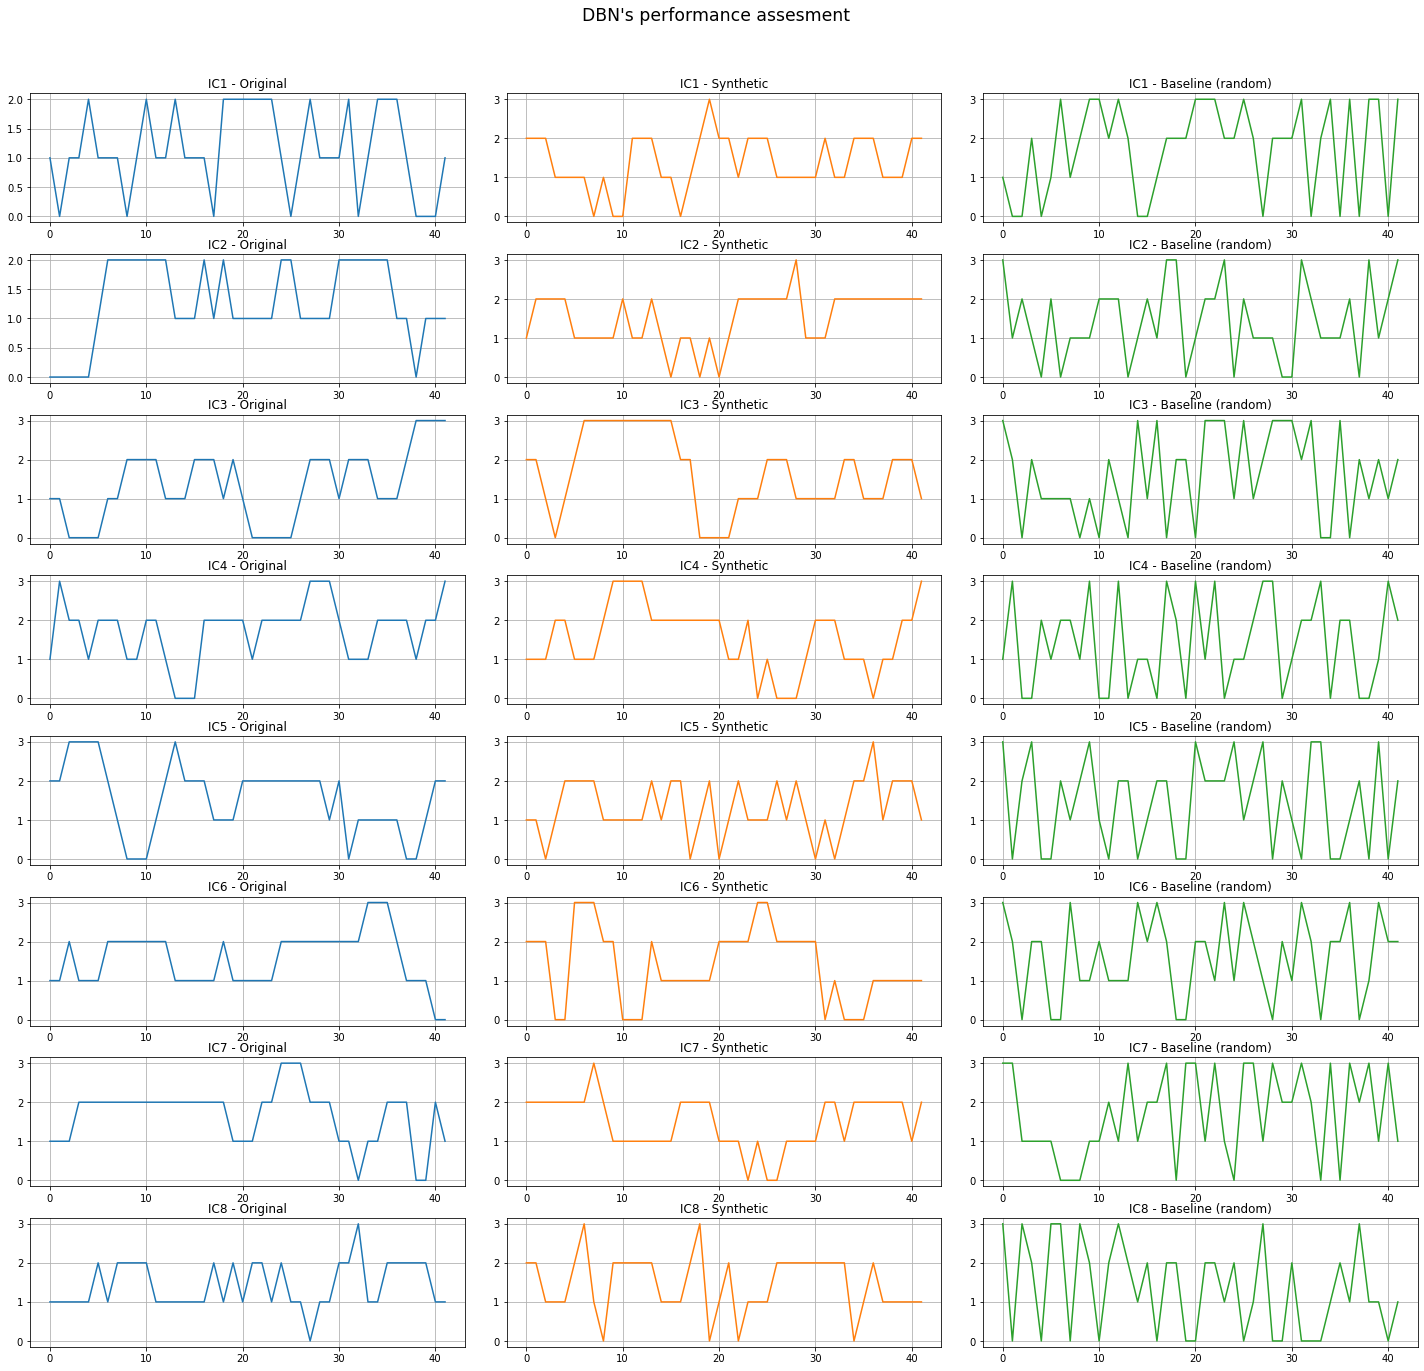

In [28]:
_, axes = plt.subplots(nrows=8, ncols=3, figsize=(20, 20))
plt.suptitle('DBN\'s performance assesment', size='xx-large')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for i, col in enumerate(df):
    s1 = [quantize_enc[v] for v in df_test[col]]
    s2 = [quantize_enc[v] for v in df_synth[col]]
    s3 = [quantize_enc[v] for v in df_base[col]]
    axes[i, 0].plot(s1, 'C0')
    axes[i, 1].plot(s2, 'C1')
    axes[i, 2].plot(s3, 'C2')
    axes[i, 0].set_title(f'{col} - Original')
    axes[i, 1].set_title(f'{col} - Synthetic')
    axes[i, 2].set_title(f'{col} - Baseline (random)')
    axes[i, 0].grid()
    axes[i, 1].grid()
    axes[i, 2].grid()

From a purely visual inspection, it seems evident that the synthetic time series is more similar to the original test set than the random baseline; to objectively measure such similarity, the **Dynamic Time Warping** (DTW) metric can be employed: it is included in the `tslearn` library (`dtw` function), among other tools for time series analysis.

Such metric will be employed to measure the distances between the original test set and the synthetic time series, and between the original test set and the baseline, in order to assess the quality of the dDBN modelled.

In [29]:
from tslearn.metrics import dtw

enc_fun = lambda x: quantize_enc[x]

# Transform dataframes into multivariate time series
s = np.vectorize(enc_fun)(df_test.to_numpy())
s_synth = np.vectorize(enc_fun)(df_synth.to_numpy())
s_base = np.vectorize(enc_fun)(df_base.to_numpy())
# Compute DTW
sim_synth = dtw(s, s_synth)
sim_base = dtw(s, s_base)
print(f'DTW distance between original and synthetic time series: {sim_synth:.2f}')
print(f'DTW distance between original time series and baseline: {sim_base:.2f}')

DTW distance between original and synthetic time series: 19.21
DTW distance between original time series and baseline: 23.60


## Conclusions
As it can be seen, according to the DTW distance the synthetic data are slightly more similar to the test set w.r.t. the random baseline: despite the fact that there is room for improvement, the dDBN proposed already manages to simulate neural connectivity in the regions considered up to a certain degree of accuracy.

## References
<a name="first">[1]</a> [Richardson et al. - Development of the social brain from age three totwelve years](https://www.nature.com/articles/s41467-018-03399-2.pdf)

<a name="second">[2]</a> [Varoquaux et al. - CanICA: Model-based extraction of reproduciblegroup-level ICA patterns from fMRI time series](https://arxiv.org/pdf/0911.4650.pdf)

<a name="third">[3]</a> [Burge et al. - Discrete Dynamic Bayesian Network Analysis of fMRI data](https://www.sciencedirect.com/science/article/pii/S0888613X1300073X)

<a name="fourth">[4]</a> [De Campos et al. - Efficient Structure Learning of Bayesian Networks using Constraints](https://jmlr.org/papers/volume12/decampos11a/decampos11a.pdf)

<a name="fifth">[5]</a> [Anne Smith - Bayesian Networks](https://synergy.st-andrews.ac.uk/vannesmithlab/research/bayesian-networks/)